In [1]:
import pandas as pd
import numpy as np

import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2809: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


### GTC_Functions

In [80]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

# data importing
raw_data = pd.read_csv('data/trade_data.csv')

class Graph_GT:
    def __init__(self, year, raw_data = raw_data):
        """
        Initialization
        self.df is a pd.dataframe for the given year
        """

        self.year = year
        self.df = raw_data.loc[raw_data['Yr']==year]
 

    def country_list(self):
        """
        raw_date should be a pd.dataframe
        
        """
        country_list = set(list(self.df.Reporting_Entity_RIC_Name)\
                           +list(self.df.Partner_Entity_RIC_Name))
        country_list = sorted(list(country_list))
        return country_list
    
    
    def graph(self):
        """
        creat a nx.graph object(weighted & directed)
        of the trading data for the given year
        """
        
        list_trade = self.df.iloc[:,[2,5,7]].values
        list_trade_nanremoved = []
        for row in list_trade:
            if np.isnan(row[2]) == False:
                list_trade_nanremoved +=  [row]
        list_trade = np.array(list_trade_nanremoved)

        #min_max_scaler = preprocessing.MinMaxScaler()
        #
        #list_trade[:,2] = min_max_scaler.fit_transform(list_trade[:,2])       
        #list_trade[:,2] = preprocessing.scale(list_trade[:,2])

        G = nx.Graph()
        nodes = []
        for row in list_trade:
            if (row[0] != 'World')*(row[1] != 'World') == 1:
            #if np.isnan(row[2])==False:
            #G.add_edge(row[0],row[1],weight = np.exp(-0.5*row[2]**2))
                #G.add_edge(row[0],row[1],weight = row[2])
                G.add_edge(row[0],row[1])
                nodes.append(row[0])
                nodes.append(row[1])
        nodes = set(nodes)
        G.add_nodes_from(nodes)
        return G
    


In [419]:
GT1920 = Graph_GT(year = 1860)

In [420]:
gra = GT1920.graph()

## Louvain Methode

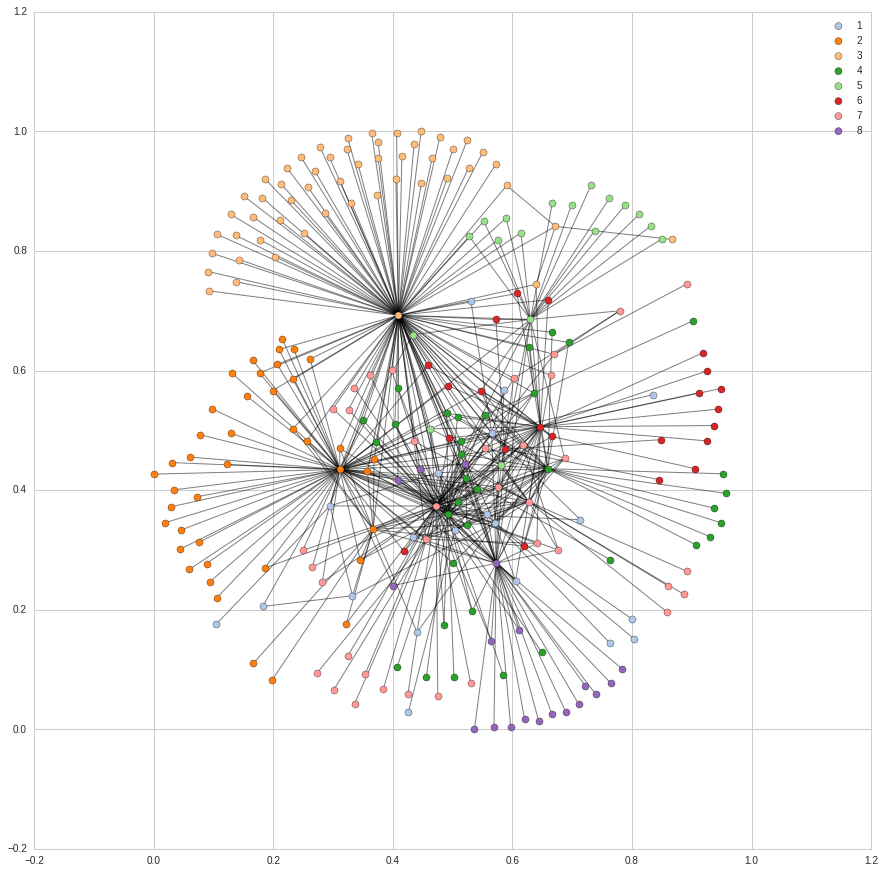

In [421]:
import community_louvain

plt.figure(figsize = [15,15])
#better with karate_graph() as defined in networkx example.
#erdos renyi don't have true community structure
G = gra

#first compute the best partition
partition = community_louvain.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.fruchterman_reingold_layout(G)
#pos = nx.spring_layout(G)
count = 0


colors = ['#1f77b4','#aec7e8','#ff7f0e','#ffbb78','#2ca02c','#98df8a','#d62728'\
          ,'#ff9896','#9467bd','#c5b0d5','#8c564b','#c49c94','#e377c2','#f7b6d2'\
          '#7f7f7f','#c7c7c7','#bcbd22','#dbdb8d','#17becf','#9edae5']

for com in set(partition.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count],label = count)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.5)

plt.show()


## Spectral Clustering

In [422]:
Lap_nom = nx.normalized_laplacian_matrix(G).todense()

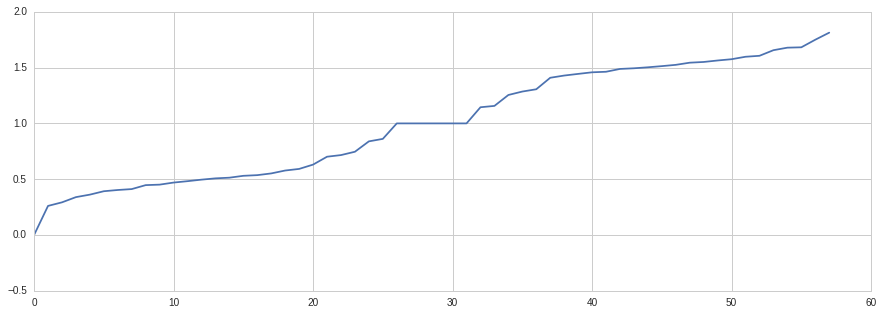

In [423]:
plt.figure(figsize = [15,5])
eig_val, eig_vec = np.linalg.eig(Lap_nom)
plt.plot(sorted(np.linalg.eig(Lap_nom)[0][0:58]))

In [447]:
k = 12
selected_vec = np.zeros([len(eig_val),k])
thr = sorted(eig_val)[k-1]
eig_val, eig_vec = np.linalg.eig(Lap_nom)
ind = 0
for i in range(len(eig_val)):
    if eig_val[i]<=thr:
        selected_vec[:,ind] = np.array(eig_vec)[:,i]
        ind += 1
        

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part


In [448]:
X = selected_vec

In [449]:
cluster_km = KMeans(n_clusters = 12,max_iter = 10000,tol = 0.00000001)
features_spectre = X
cluster_km.fit(features_spectre)
pred = cluster_km.predict(X)

dict_predict = {}
for i in range(len(G.nodes())):
    dict_predict.update(
    {
            G.nodes()[i] : int(pred[i])
        })

In [450]:
#dict_predict

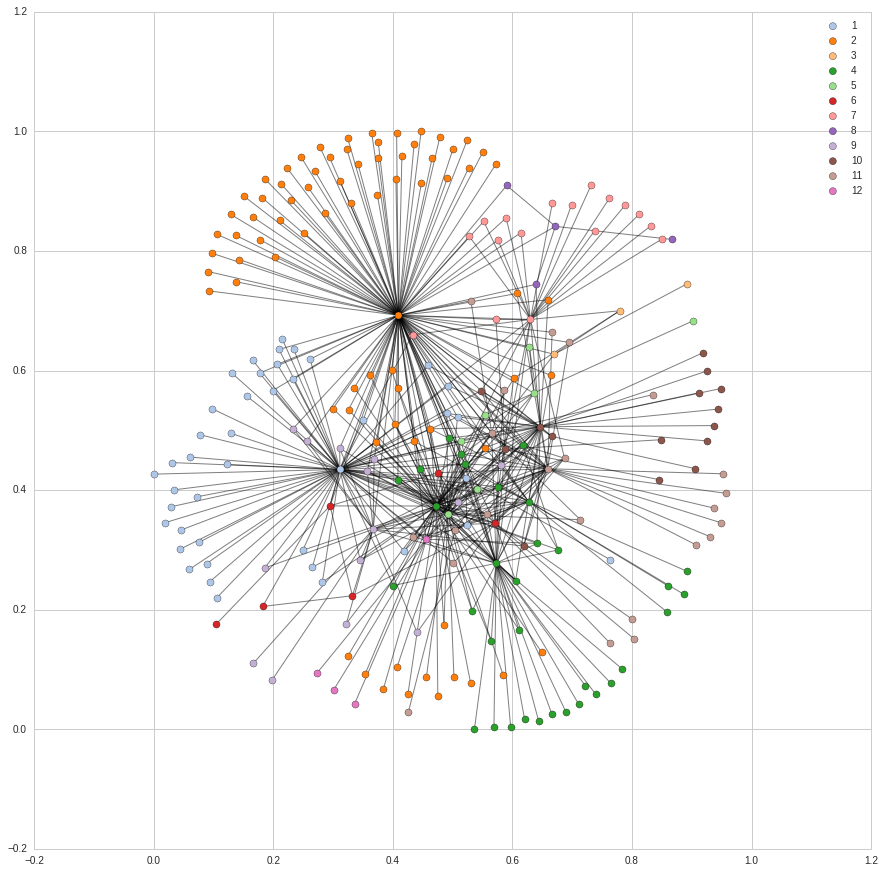

In [451]:
plt.figure(figsize = [15,15])
count = 0
for com in set(dict_predict.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in dict_predict.keys()
                                if dict_predict[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50,
                                node_color = colors[count],label = count)

plt.legend()
nx.draw_networkx_edges(G,pos, alpha=0.5)

plt.show()
